In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.morphology as skm

In [2]:
#This code is aimed towards getting a daily, domain maximum time series of BARPAC data, using all spatial points

In [3]:
#Load 5 days of ACCESS-forced sample data (10-minute wind gusts over whole domain)

f = xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/cmip5/ACCESS1-0/historical/r1i1p1/20041103T0000Z/20041203T0000Z/pp26/*")

In [4]:
#Now calculate the wind gust ratio.
#Note assertion/assumption is that data is 10-minute, because xarray rolling can't handle time-aware windows

assert f.time_coverage_resolution == 'PT9M59S', "CHECK TIME OUTPUT FREQUENCY, IS NOT EQUAL TO 10 MINS, SO ROLLING WINDOW MIGHT NEED TO BE CHANGED"

f["wgr"] = f.max_wndgust10m / (f.max_wndgust10m.rolling(time=24, min_periods=6, center=True).mean())

In [5]:
#Now calculate the daily maximum gust, and keep the wgr for those gusts.
#Best I could do is a loop for now. Think it should be efficient enough when qsubbed

dmax_wgr = []
times = []
for name, group in f.groupby("time.date"):
    times.append(name)
    dmax_wgr.append(xr.where(group.max_wndgust10m == group.max_wndgust10m.max("time"),group.wgr,np.nan).max("time"))
    
dmax_wgr = xr.concat(dmax_wgr,"date")
dmax_wgr["date"] = times

#Resample gusts to daily max as usual
dmax_gust = f["max_wndgust10m"].groupby("time.date").max()

In [6]:
#Load the daily max lightning field
l = xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/cmip5/ACCESS1-0/historical/r1i1p1/20041103T0000Z/20041203T0000Z/pp0/*")
l["time"] = pd.to_datetime(l.time.values).floor("D")
l = l.rename({"time":"date"})

In [7]:
#Combine into one Dataset
ds=xr.Dataset({"wgr_dmax":dmax_wgr,"gust_dmax":dmax_gust,"lightning":l["n_lightning_fl"]})

#Create a binary lightning field, and dialate this field using a 50 km radius

# def dialation(X):
#     def func(x):
#         return [skm.binary_dilation(x[i,:,:], disk) for i in np.arange(x.shape[0])]
#     return xr.apply_ufunc(func, X, dask="allowed")

# disk = skm.disk(radius_pixels)

# ds["lightning50"] = dialation( (ds.lightning >= 1) ) * 1

#Could also use rolling max for lightning, as this is more consistent with what we did for station locations.

dx_km = 2.2
radius_km = 50
radius_pixels = int(np.floor(radius_km / dx_km))


ds["lightning50"] = ds.lightning.rolling(dim={"latitude":radius_pixels, "longitude":radius_pixels},center=True).sum()
ds = ds.drop(["height","realization","forecast_period","forecast_reference_time"]).drop_indexes(["date","latitude","longitude"]).persist()

In [8]:
#Mask ocean
barpa_lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/lnd_mask-BARPAC-M_km2p2.nc")
ds = xr.where(barpa_lsm.lnd_mask==1,ds,np.nan)


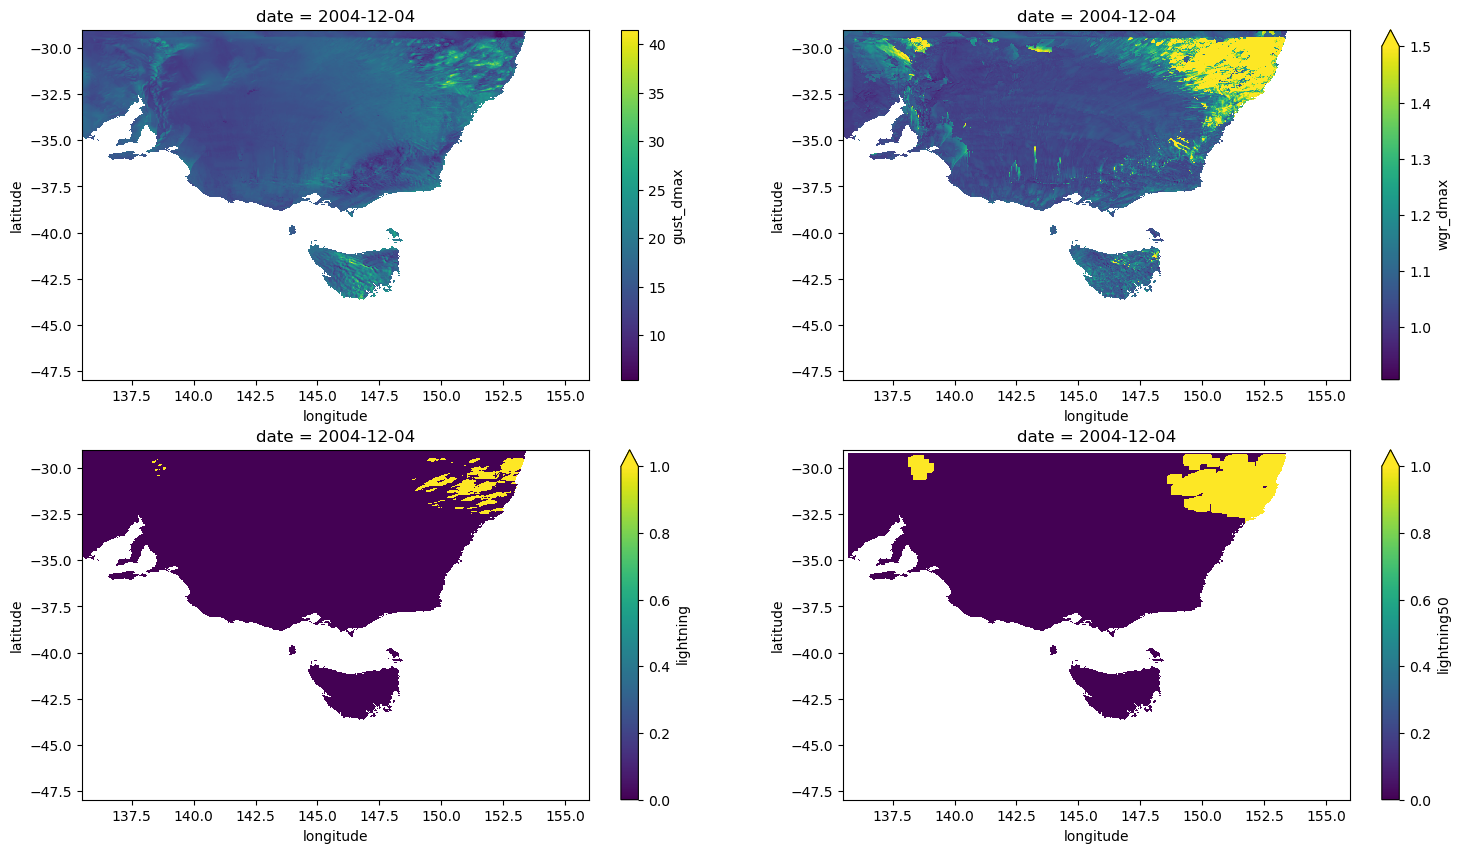

In [9]:
plt.figure(figsize=[18,10])
plt.subplot(2,2,1)
ds.gust_dmax.isel(date=1).plot()

plt.subplot(2,2,2)
ds.wgr_dmax.isel(date=1).plot(vmax=1.5)

plt.subplot(2,2,3)
ds.lightning.isel(date=1).plot(vmax=1)

plt.subplot(2,2,4)
ds.lightning50.isel(date=1).plot(vmax=1)

In [10]:
#Get the spatial locations of the domain maximum gust
argmax = ds.gust_dmax.argmax(["latitude","longitude"])

#Get the daily domain max gust and output as a pandas dataframe
ddmax = ds.isel(latitude=argmax["latitude"].expand_dims("points").compute(), 
                  longitude=argmax["longitude"].expand_dims("points").compute())
ddmax.to_dataframe()

wgr_dmax  gust_dmax  lightning  lightning50   latitude  \
points date                                                           
0      0     1.071537  32.314453        0.0          0.0 -43.500000   
       1     1.520830  41.496094        0.0          0.0 -41.599998   
       2     1.293698  41.058594        0.0          0.0 -41.619999   
       3     2.206366  30.640625        5.0        294.0 -30.199999   
       4     2.239366  30.801758        1.0        427.0 -29.920000   

              longitude  
points date              
0      0     146.759995  
       1     146.380005  
       2     146.380005  
       3     147.699997  
       4     143.979996

In [11]:
#Do the same but for convective gusts
argmax_conv = ds.gust_dmax.where(ds.lightning50 >= 1, np.nan).argmax(["latitude","longitude"],skipna=True)
ddmax_conv = ds.isel(latitude=argmax_conv["latitude"].expand_dims("points").compute(), 
                  longitude=argmax_conv["longitude"].expand_dims("points").compute())
ddmax_conv.to_dataframe()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:1071: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


wgr_dmax  gust_dmax  lightning  lightning50   latitude  \
points date                                                           
0      0     2.300131  27.199219        0.0          3.0 -31.820000   
       1     2.765845  40.342773        0.0         26.0 -31.840000   
       2     1.019072  20.541992        0.0         96.0 -29.820000   
       3     2.206366  30.640625        5.0        294.0 -30.199999   
       4     2.239366  30.801758        1.0        427.0 -29.920000   

              longitude  
points date              
0      0     139.000000  
       1     150.240005  
       2     151.520004  
       3     147.699997  
       4     143.979996

In [12]:
#Do the same but for convective gusts where wgr >= 1.5
argmax_conv_wgr = ds.gust_dmax.where((ds.lightning50 >= 1) & (ds.wgr_dmax >= 1.5), np.nan).argmax(["latitude","longitude"],skipna=True)
ddmax_conv_wgr = ds.isel(latitude=argmax_conv_wgr["latitude"].expand_dims("points").compute(), 
                  longitude=argmax_conv_wgr["longitude"].expand_dims("points").compute())
ddmax_conv_wgr.to_dataframe()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:1071: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


wgr_dmax  gust_dmax  lightning  lightning50   latitude  \
points date                                                           
0      0     2.300131  27.199219        0.0          3.0 -31.820000   
       1     2.765845  40.342773        0.0         26.0 -31.840000   
       2     1.786744  19.915039        0.0        155.0 -30.139999   
       3     2.206366  30.640625        5.0        294.0 -30.199999   
       4     2.239366  30.801758        1.0        427.0 -29.920000   

              longitude  
points date              
0      0     139.000000  
       1     150.240005  
       2     151.639999  
       3     147.699997  
       4     143.979996

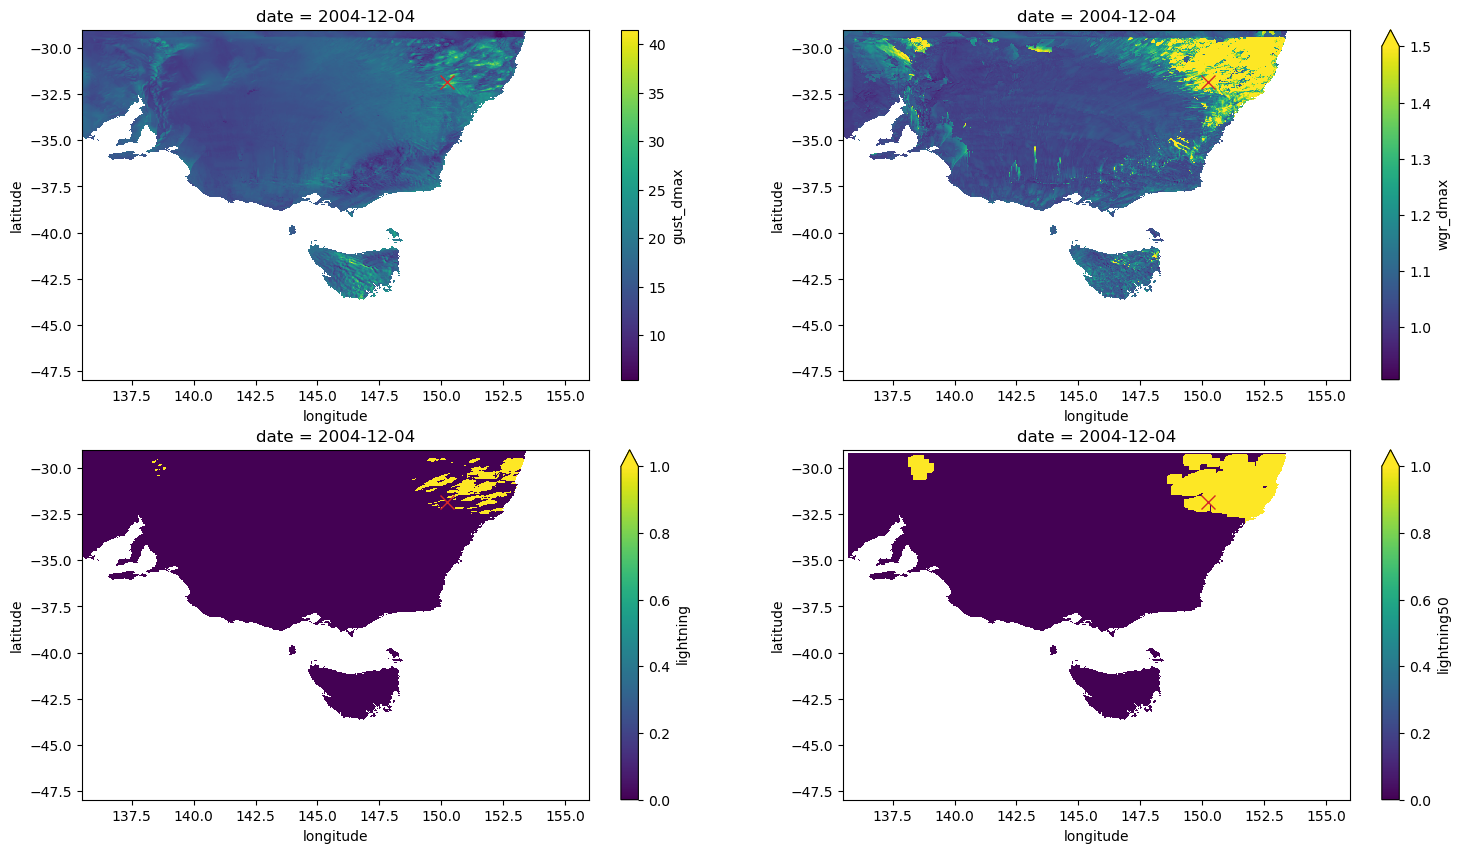

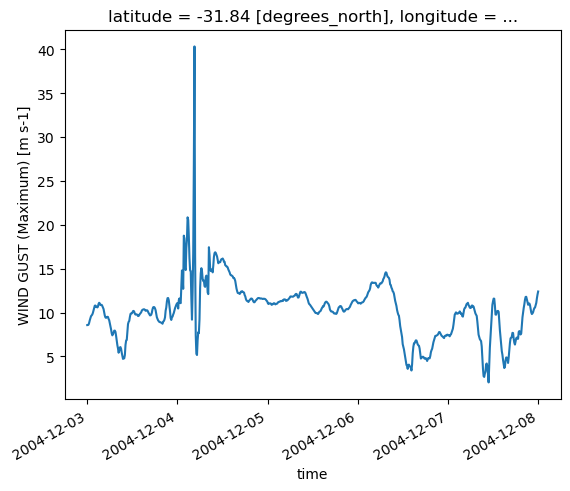

In [20]:
idate = 1
lat, lon = ddmax_conv_wgr.to_dataframe().loc[0,idate][["latitude","longitude"]].values

plt.figure(figsize=[18,10])
plt.subplot(2,2,1)
ds.gust_dmax.isel(date=idate).plot()
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(2,2,2)
ds.wgr_dmax.isel(date=idate).plot(vmax=1.5)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(2,2,3)
ds.lightning.isel(date=idate).plot(vmax=1)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(2,2,4)
ds.lightning50.isel(date=idate).plot(vmax=1)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.figure()
f.max_wndgust10m.sel(latitude=lat,longitude=lon).plot()